In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm
import torchvision.datasets as datasets
from datasets import load_dataset


In [2]:
ds = load_dataset("C:/Thesis/Dataset4classes", num_proc=3)
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "C:/Thesis/Segmented_ds_4c/train")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg") or file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder



Resolving data files:   0%|          | 0/38591 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/356 [00:00<?, ?it/s]

In [3]:
# ROOT_DIR = os.path.join(cwd, "C:/Thesis/Dataset4classes2/valid")

# for folder in os.listdir(ROOT_DIR):
#     for file in os.listdir(os.path.join(ROOT_DIR, folder)):
#         if file.endswith(".jpg") or file.endswith(".png"):
#             full_name = os.path.join(ROOT_DIR, folder, file)
#             labels[full_name] = folder


In [4]:
files = labels.keys()

In [5]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)
transform_image = T.Compose([
    T.Resize(244),                # Escala el lado más corto a 244 píxeles
    T.CenterCrop(224),            # Recorta una región central de 224x224
    T.ToTensor(),                 # Convierte la imagen a tensor
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliza con mean y std de ImageNet
])

Using cache found in C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
# Crea un tensor de entrada y muévelo al dispositivo
dummy_input = torch.rand(1, 3, 224, 224).to(device)

# Genera los embeddings
embeddings = dinov2_vits14(dummy_input)

# Verifica las dimensiones de los embeddings
print(embeddings.shape)                 # Verificar dimensiones

torch.Size([1, 1536])


In [7]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [8]:
embeddings = compute_embeddings(files)

  0%|          | 0/16769 [00:00<?, ?it/s]

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from random import shuffle

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

combined = list(zip(embedding_list, y))

# Barajar
shuffle(combined)

# Separar nuevamente
embedding_list, y = zip(*combined)
embedding_list = np.array(embedding_list).squeeze(1)  # Quita la dimensión de tamaño 1

In [10]:
!pip install cuml

Defaulting to user installation because normal site-packages is not writeable
  Using cached cuml-0.6.1.post1.tar.gz (1.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for cuml
Failed to build cuml


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [47 lines of output]
      running bdist_wheel
      running build
      C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_distutils\cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
      !!
      
              ********************************************************************************
              Please avoid running ``setup.py`` directly.
              Instead, use pypa/build, pypa/installer or other
              standards-based tools.
      
              See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
              ********************************************************************************
      
      !!
        self.initialize_options()
      installing to build\bdist.win-amd64\wheel
      running install
      Traceback (most recent call last):
        File "<string>", line 2, in <m

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Supongamos que ya tienes tus embeddings y etiquetas en arrays
# embedding_array: numpy array con tus datos de entrada
# y_array: numpy array con tus etiquetas

# Definir el modelo SVM
svm = SVC(C = 10, gamma = 0.001, kernel= 'rbf')


svm.fit(embedding_list, y)
y_pred = svm.predict(embedding_list)
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

         bcc       1.00      1.00      1.00      4223
         mel       1.00      1.00      1.00      4222
      others       1.00      1.00      1.00      4100
         scc       1.00      1.00      1.00      4224

    accuracy                           1.00     16769
   macro avg       1.00      1.00      1.00     16769
weighted avg       1.00      1.00      1.00     16769



In [12]:
from sklearn.metrics import classification_report, accuracy_score

In [13]:
ROOT_DIR = os.path.join(cwd, "C:/Thesis/Segmented_ds_4c/valid")


labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg") or file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

testfiles = labels.keys()
testembeddings = compute_embeddings(testfiles)

y_val = [labels[file] for file in testfiles]
y_val_pred = svm.predict(np.array(list(testembeddings.values())).squeeze(1))





  0%|          | 0/1010 [00:00<?, ?it/s]

In [14]:
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

Accuracy: 0.9336633663366337
Classification Report:
               precision    recall  f1-score   support

         bcc       0.94      1.00      0.97       300
         mel       0.93      0.87      0.90       300
      others       0.93      0.92      0.93       348
         scc       0.94      1.00      0.97        62

    accuracy                           0.93      1010
   macro avg       0.93      0.95      0.94      1010
weighted avg       0.93      0.93      0.93      1010



In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

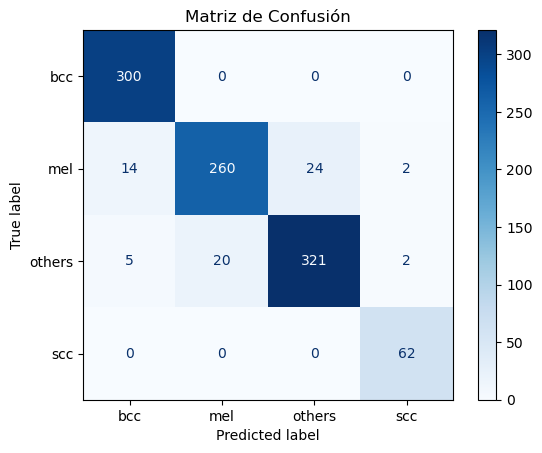

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


model = XGBClassifier(n_estimators=495, 
                      max_depth=9, 
                      learning_rate= 0.07513291174284646, 
                      subsample=0.8103606987549683, 
                      colsample_bytree = 0.7897168158886071, 
                      gamma = 0.2932845334464851, 
                      reg_alpha = 8.968869453424377,
                      reg_lambda = 6.468487200733069, 
                      min_child_weight = 8)

model.fit(embedding_list, y_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7897168158886071, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2932845334464851,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07513291174284646,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=495, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
y_val_encoded = label_encoder.fit_transform(y_val)
y_pred = model.predict(np.array(list(testembeddings.values())).squeeze(1))

print("Accuracy:", accuracy_score(y_val_encoded, y_pred))
print("Classification Report:\n", classification_report(y_val_encoded, y_pred))

Accuracy: 0.8841584158415842
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       300
           1       0.91      0.78      0.84       300
           2       0.89      0.88      0.88       348
           3       0.73      0.98      0.84        62

    accuracy                           0.88      1010
   macro avg       0.86      0.90      0.87      1010
weighted avg       0.89      0.88      0.88      1010



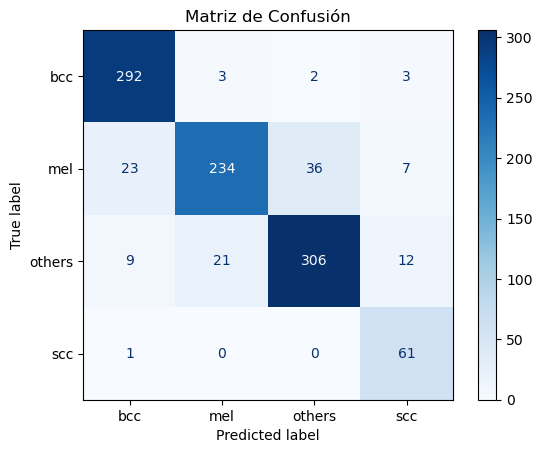

In [19]:
# Calcular matriz de confusión
cm = confusion_matrix(y_val_encoded, y_pred)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()

In [20]:
param_grid = {
    'n_estimators': [300],  # Número de árboles en el bosque
    'max_depth': [11],               # Profundidad máxima del árbol
    'learning_rate': [0.15],    # Tasa de aprendizaje
    'subsample': [0.9],           # Proporción de muestras utilizadas para entrenar cada árbol
    'colsample_bytree': [0.9],    # Proporción de características utilizadas para entrenar cada árbol
    'gamma': [0.4],            # Reducción mínima de la pérdida requerida para hacer una división
    'reg_alpha': [1.0],                  # Término de regularización L1 en pesos
    'reg_lambda': [1.0],                 # Término de regularización L2 en pesos
    'min_child_weight': [1]               # Peso mínimo necesario para crear un nuevo nodo en el árbol
}


In [21]:
grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=2,
    n_jobs=-1
)

# Ejecutar la búsqueda de hiperparámetros
grid_search_xgb.fit(embedding_list, y_encoded)


Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\abadd\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\abadd\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     predictor='gpu_predictor', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.9], 'gamma': [0.4],
                         'learning_rate': [0.15], 'max_depth': [11],
                         'min_child_weight': [1], 'n_estimators': [300],
                         'reg_alpha': [1.0], 'reg_lambda': [1.0],
                         'subsample': [0.9]},
             scoring='accuracy', verbose=2)

In [22]:
model = XGBClassifier(n_estimators=300, 
                      max_depth=11, 
                      learning_rate= 0.15, 
                      subsample=0.9, 
                      colsample_bytree = 0.9, 
                      gamma = 0.4, 
                      reg_alpha = 1.0,
                      reg_lambda = 1.0, 
                      min_child_weight = 1)

model.fit(embedding_list, y_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:
print("Mejores hiperparámetros:", grid_search_xgb.best_params_)
print("Mejor puntuación:", grid_search_xgb.best_score_)


Mejores hiperparámetros: {'colsample_bytree': 0.9, 'gamma': 0.4, 'learning_rate': 0.15, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.9}
Mejor puntuación: 0.8106028535154011


In [24]:
y_val_encoded = label_encoder.fit_transform(y_val)
y_val_pred_xgb = model.predict(np.array(list(testembeddings.values())).squeeze(1))

print("Accuracy en datos de validación:", accuracy_score(y_val_encoded, y_val_pred_xgb))
print("Classification Report en datos de validación:\n", classification_report(y_val_encoded, y_val_pred_xgb))


Accuracy en datos de validación: 0.8732673267326733
Classification Report en datos de validación:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       300
           1       0.88      0.76      0.81       300
           2       0.88      0.86      0.87       348
           3       0.72      0.97      0.83        62

    accuracy                           0.87      1010
   macro avg       0.85      0.89      0.86      1010
weighted avg       0.88      0.87      0.87      1010



In [25]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np  
from sklearn.model_selection import StratifiedKFold

In [26]:
lgbm = LGBMClassifier(boosting_type= 'gbdt', num_leaves=100,        # Ajustar alrededor de 50
    learning_rate=0.2,# Refinar cerca de 0.1
    n_estimators =500,   # Explorar alrededor de 200
    max_depth= 10,          # Ajustar cerca de 10
    min_child_samples=30,
    device='gpu')

In [27]:
# Ejecutar la búsqueda de hiperparámetros
lgbm.fit(embedding_list, y)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 16769, number of used features: 1536
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1536 dense feature groups (24.56 MB) transferred to GPU in 0.014785 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.378986
[LightGBM] [Info] Start training from score -1.379223
[LightGBM] [Info] Start training from score -1.408545
[LightGBM] [Info] Start training from score -1.378749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

LGBMClassifier(device='gpu', learning_rate=0.2, max_depth=10,
               min_child_samples=30, n_estimators=500, num_leaves=100)

In [28]:
y_pred_train = lgbm.predict(embedding_list)
print("Clasificación en conjunto de entrenamiento:\n", classification_report(y, y_pred_train))

Clasificación en conjunto de entrenamiento:
               precision    recall  f1-score   support

         bcc       1.00      1.00      1.00      4223
         mel       1.00      1.00      1.00      4222
      others       1.00      1.00      1.00      4100
         scc       1.00      1.00      1.00      4224

    accuracy                           1.00     16769
   macro avg       1.00      1.00      1.00     16769
weighted avg       1.00      1.00      1.00     16769



Exactitud: 0.9148514851485149
Reporte de Clasificación:
               precision    recall  f1-score   support

         bcc       0.93      1.00      0.96       300
         mel       0.93      0.82      0.87       300
      others       0.92      0.91      0.92       348
         scc       0.79      1.00      0.89        62

    accuracy                           0.91      1010
   macro avg       0.89      0.93      0.91      1010
weighted avg       0.92      0.91      0.91      1010



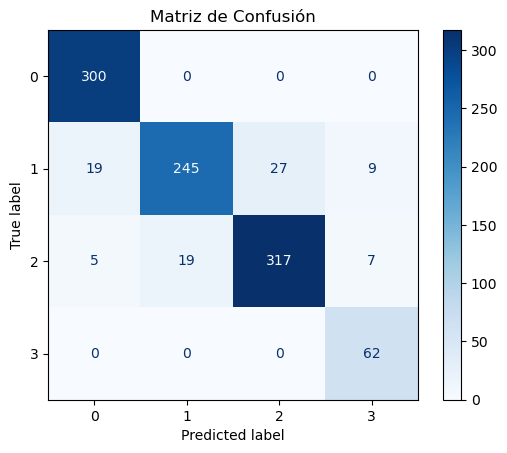

In [29]:
y_pred = lgbm.predict(np.array(list(testembeddings.values())).squeeze(1))

# Evaluar el modelo
accuracy = accuracy_score(y_val, y_pred)
print("Exactitud:", accuracy)
print("Reporte de Clasificación:\n", classification_report(y_val, y_pred))

# Matriz de Confusión
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [30]:
import numpy as np
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score

# ================
# 1. Prepara tus datos
# ================
# Asumo que tienes tus embeddings en 'embedding_list' (array numpy) 
# y las etiquetas originales (string) en la lista/array 'y'.
# Del mismo modo, tienes embeddings de validación 'test_embedding_list' y 'y_val'.
# Asegúrate de que 'embedding_list' sea de la forma (n_muestras, n_características)

embedding_list = np.array(embedding_list)  # Si no lo has convertido a array
test_embedding_list = np.array(list(testembeddings.values())).squeeze(1)  # según tu código

# Codificar las etiquetas de entrenamiento
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)          # Convierte etiquetas texto -> numérico

# Codificar las etiquetas de validación
y_val_encoded = label_encoder.transform(y_val)      # Mismo codificador

# ================
# 2. Define tus modelos base
# ================
svm_clf = SVC(
    C=10, 
    gamma=0.001, 
    kernel='rbf',
    probability=True  # Necesario si quieres "soft voting"; opcional para "hard voting"
)

xgb_clf = XGBClassifier(
    n_estimators=495, 
    max_depth=9, 
    learning_rate=0.07513291174284646, 
    subsample=0.8103606987549683, 
    colsample_bytree=0.7897168158886071, 
    gamma=0.2932845334464851, 
    reg_alpha=8.968869453424377,
    reg_lambda=6.468487200733069, 
    min_child_weight=8,
    use_label_encoder=False,  # Si tu versión de XGBoost lo requiere
    eval_metric='mlogloss'
)

lgbm_clf = LGBMClassifier(
    boosting_type='gbdt', 
    num_leaves=100,
    learning_rate=0.2,
    n_estimators=500,
    max_depth=10,
    min_child_samples=30,
    device='gpu'
)

# ================
# 3. Construir el VotingClassifier
# ================
# Puedes usar voting='hard' (voto mayoritario)
# o voting='soft' (promedio de probabilidades).
# Para 'soft', asegúrate de que cada modelo sea capaz de dar probabilidades
# (por ejemplo, SVC con probability=True).
voting_ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_clf),
        ('xgb', xgb_clf),
        ('lgbm', lgbm_clf)
    ],
    voting='hard',  # o 'soft' si quieres promediar probabilidades
    n_jobs=3
)

# ================
# 4. Entrenar el ensemble
# ================
voting_ensemble.fit(embedding_list, y_encoded)

# ================
# 5. Evaluar desempeño en conjunto de validación
# ================
y_val_pred_ensemble = voting_ensemble.predict(test_embedding_list)

print("Exactitud del Ensemble en validación:",
      accuracy_score(y_val_encoded, y_val_pred_ensemble))

print("Reporte de Clasificación del Ensemble:\n",
      classification_report(y_val_encoded, y_val_pred_ensemble))


Exactitud del Ensemble en validación: 0.9158415841584159
Reporte de Clasificación del Ensemble:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       300
           1       0.94      0.82      0.88       300
           2       0.92      0.91      0.92       348
           3       0.83      1.00      0.91        62

    accuracy                           0.92      1010
   macro avg       0.90      0.93      0.91      1010
weighted avg       0.92      0.92      0.91      1010



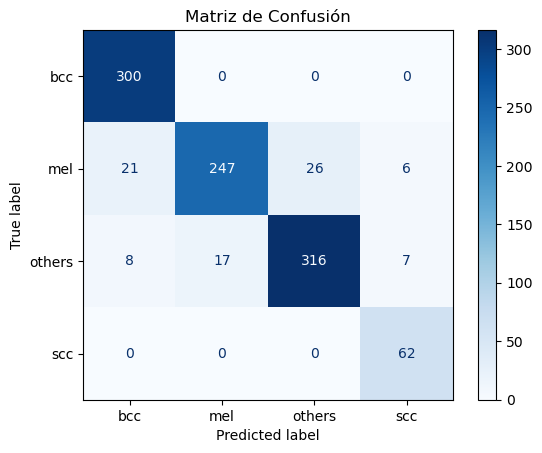

In [31]:
# Calcular matriz de confusión
cm = confusion_matrix(y_val_encoded, y_val_pred_ensemble)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()

In [32]:
voting_ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_clf),
        ('xgb', xgb_clf),
        ('lgbm', lgbm_clf)
    ],
    voting='soft',  # o 'soft' si quieres promediar probabilidades
    n_jobs=3
)

In [33]:
voting_ensemble.fit(embedding_list, y_encoded)

# ================
# 5. Evaluar desempeño en conjunto de validación
# ================
y_val_pred_ensemble = voting_ensemble.predict(test_embedding_list)

print("Exactitud del Ensemble en validación:",
      accuracy_score(y_val_encoded, y_val_pred_ensemble))

print("Reporte de Clasificación del Ensemble:\n",
      classification_report(y_val_encoded, y_val_pred_ensemble))

Exactitud del Ensemble en validación: 0.9287128712871288
Reporte de Clasificación del Ensemble:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       300
           1       0.94      0.85      0.89       300
           2       0.93      0.93      0.93       348
           3       0.86      1.00      0.93        62

    accuracy                           0.93      1010
   macro avg       0.92      0.94      0.93      1010
weighted avg       0.93      0.93      0.93      1010



In [34]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm
import torchvision.datasets as datasets
from datasets import load_dataset

In [35]:
ds = load_dataset("C:/Tesis/DatasetBinario", num_proc=3)
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "C:/Tesis/DatasetBinario/train")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg") or file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

Resolving data files:   0%|          | 0/20959 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/761 [00:00<?, ?it/s]

In [ ]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)
transform_image = T.Compose([
    T.Resize(244),                # Escala el lado más corto a 244 píxeles
    T.CenterCrop(224),            # Recorta una región central de 224x224
    T.ToTensor(),                 # Convierte la imagen a tensor
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliza con mean y std de ImageNet
])

Using cache found in C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main


In [34]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
     Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from random import shuffle

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

combined = list(zip(embedding_list, y))

# Barajar
shuffle(combined)

# Separar nuevamente
embedding_list, y = zip(*combined)
embedding_list = np.array(embedding_list).squeeze(1)  # Quita la dimensión de tamaño 1


In [ ]:
embeddings = compute_embeddings(files)

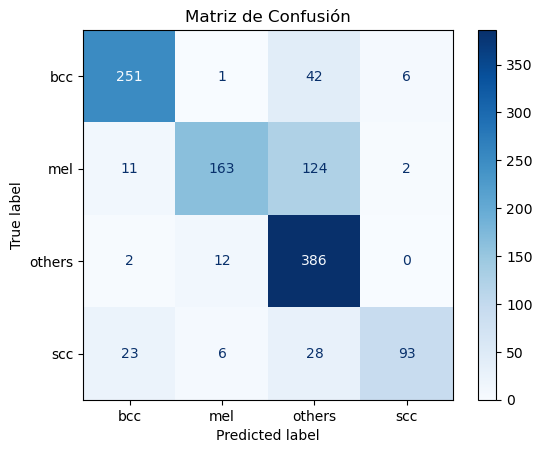

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

svm = SVC(C = 10, gamma = 0.001, kernel= 'rbf')

svm.fit(embedding_list, y)


# Evaluar en datos de prueba (opcional)
y_pred = svm.predict(embedding_list)
print(classification_report(y, y_pred))